In [1]:
import numpy as np
import pyldpc as ldpc
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import sys
from utils_f import load_code
import os
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device='cuda:1'

In [3]:
H_filename = './source/BCH_15_11.alist'
code = load_code(H_filename)
H = code.H
G = code.G
var_degrees = code.var_degrees
chk_degrees = code.chk_degrees
num_edges = code.num_edges
u = code.u
d = code.d
n = code.n
m = code.m
k = code.k

In [4]:
class min_sum(torch.nn.Module):
    def __init__(self, num_iterations = 5):
        super(min_sum, self).__init__()
        self.W_cv = torch.ones((num_iterations, num_edges))
        # self.W_cv = torch.nn.Parameter(torch.abs(torch.ones((num_iterations, num_edges))))
        # self.W_cv.requires_grad = True
        self.B_cv = torch.zeros((num_iterations, num_edges))
        # self.B_cv = torch.nn.Parameter(torch.abs(torch.zeros((num_iterations, num_edges))))
        # self.B_cv.requires_grad = True
        self.W_vc = torch.ones((num_iterations, num_edges))
        # self.W_vc = torch.nn.Parameter(torch.abs(torch.ones((num_iterations, num_edges))))
        # self.W_vc.requires_grad = True
        
        self.num_iterations = num_iterations
        
    def forward(self, soft_input):
        soft_input = soft_input.T           # TODO! Fix matrix dimensions inside functions
        # print(soft_input.shape)
        cv = torch.zeros((num_edges, soft_input.shape[1]))
        for iteration in range(0, self.num_iterations):
            vc = self.compute_vc(cv, soft_input, iteration)
            cv = self.compute_cv(vc, iteration)
            soft_input = self.marginalize(soft_input, cv)
        output = torch.sigmoid(-soft_input)
        output = output.T
        
        # self.W_cv = torch.nn.Parameter(torch.abs(self.W_cv))
        # self.B_cv =torch.nn.Parameter(torch.abs(self.B_cv))
        # self.W_vc = torch.nn.Parameter(torch.abs(self.W_vc))
        # output = soft_input
        return output

        
    def compute_vc(self, cv, soft_input, iteration):
        edges = []
        for i in range(0, n):
            for j in range(0, var_degrees[i]):
                edges.append(i)
        # print(soft_input.shape, len(edges), edges)
        reordered_soft_input = torch.index_select(soft_input, 0, torch.tensor(edges).to(device))

        vc = torch.zeros((num_edges, cv.shape[1])).to(device)
        counter = 0
        edge_order = []

        for i in range(0, n): # for each variable node v
            for j in range(0, var_degrees[i]):
                edge_order.append(d[i][j])
                extrinsic_edges = []
                for jj in range(0, var_degrees[i]):
                    if jj != j: # extrinsic information only
                        extrinsic_edges.append(d[i][jj])
                # if the list of edges is not empty, add them up
                if extrinsic_edges:
                    # print(cv.shape, len(extrinsic_edges), extrinsic_edges)
                    temp = torch.index_select(cv.to(device), 0, torch.tensor(extrinsic_edges).to(device))
                    temp = torch.sum(temp, 0)
                else:
                    temp = torch.zeros(cv.shape[1])

                temp = temp.to(device)
                vc[counter] = temp
        
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.arange(0, num_edges)
        vc = torch.index_select(vc, 0, torch.tensor(new_order).to(device))
        vc += reordered_soft_input * torch.tile(torch.reshape(self.W_vc[iteration], (-1,1)), (1, cv.shape[1])).to(device)       # add soft inputs of the previous iterations!
        return vc 

    def compute_cv(self, vc, iteration):
        cv_list = []
        prod_list = []
        min_list = []
        edge_order = []
        for i in range(0, m): # for each check node c
            for j in range(0, chk_degrees[i]):
                edge_order.append(u[i][j])
                extrinsic_edges = []
                for jj in range(0, chk_degrees[i]):
                    if jj != j:
                        extrinsic_edges.append(u[i][jj])
                temp = torch.index_select(vc.to(device),0,torch.tensor(extrinsic_edges).to(device))
                temp1 = torch.prod(torch.sign(temp),0)
                temp2 = torch.min(torch.abs(temp),0)[0]
                prod_list.append(temp1)
                min_list.append(temp2)
        prods = torch.stack(prod_list)
        mins = torch.stack(min_list)
        mins = torch.relu(mins - torch.tile(torch.reshape(self.B_cv[iteration], (-1,1)), (1, vc.shape[1])).to(device))
        cv = prods * mins
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.array(range(0,num_edges)).astype(int)
        cv = torch.index_select(cv, 0, torch.tensor(new_order).to(device))
        cv = cv * torch.tile(torch.reshape(self.W_cv[iteration], (-1,1)), (1, vc.shape[1])).to(device)
        return cv

    # combine messages to get posterior LLRs
    def marginalize(self, soft_input, cv):
        weighted_soft_input = soft_input
        soft_output = []
        for i in range(0,n):
            edges = []
            for e in range(0,var_degrees[i]):
                edges.append(d[i][e])
            temp = torch.index_select(cv,0,torch.tensor(edges).to(device))
            temp = torch.sum(temp, 0)
            soft_output.append(temp)
        soft_output = torch.stack(soft_output)
        soft_output = weighted_soft_input + soft_output
        return soft_output

In [5]:
class Decoder(torch.nn.Module):
    def __init__(self, num_iterations = 5):
        super(Decoder, self).__init__()
        # self.W_cv = torch.ones((num_iterations, num_edges))
        self.W_cv = torch.nn.Parameter(torch.abs(torch.randn((num_iterations, num_edges))))
        self.W_cv.requires_grad = True
        # self.B_cv = torch.zeros((num_iterations, num_edges))
        self.B_cv = torch.nn.Parameter(torch.abs(torch.randn((num_iterations, num_edges))))
        self.B_cv.requires_grad = True
        # self.W_vc = torch.ones((num_iterations, num_edges))
        self.W_vc = torch.nn.Parameter(torch.abs(torch.randn((num_iterations, num_edges))))
        self.W_vc.requires_grad = True
        
        self.num_iterations = num_iterations
        
    def forward(self, soft_input):
        soft_input = soft_input.T           # TODO! Fix matrix dimensions inside functions
        # print(soft_input.shape)
        cv = torch.zeros((num_edges, soft_input.shape[1]))
        for iteration in range(0, self.num_iterations):
            vc = self.compute_vc(cv, soft_input, iteration)
            cv = self.compute_cv(vc, iteration)
            soft_input = self.marginalize(soft_input, cv)
        output = torch.sigmoid(-soft_input)
        output = output.T
        
        # self.W_cv = torch.nn.Parameter(torch.abs(self.W_cv))
        # self.B_cv =torch.nn.Parameter(torch.abs(self.B_cv))
        # self.W_vc = torch.nn.Parameter(torch.abs(self.W_vc))
        
        # output = soft_input
        return output

        
    def compute_vc(self, cv, soft_input, iteration):
        edges = []
        for i in range(0, n):
            for j in range(0, var_degrees[i]):
                edges.append(i)
        # print(soft_input.shape, len(edges), edges)
        reordered_soft_input = torch.index_select(soft_input, 0, torch.tensor(edges).to(device))

        vc = torch.zeros((num_edges, cv.shape[1])).to(device)
        counter = 0
        edge_order = []

        for i in range(0, n): # for each variable node v
            for j in range(0, var_degrees[i]):
                edge_order.append(d[i][j])
                extrinsic_edges = []
                for jj in range(0, var_degrees[i]):
                    if jj != j: # extrinsic information only
                        extrinsic_edges.append(d[i][jj])
                # if the list of edges is not empty, add them up
                if extrinsic_edges:
                    # print(cv.shape, len(extrinsic_edges), extrinsic_edges)
                    temp = torch.index_select(cv.to(device), 0, torch.tensor(extrinsic_edges).to(device))
                    temp = torch.sum(temp, 0)
                else:
                    temp = torch.zeros(cv.shape[1])

                temp = temp.to(device)
                vc[counter] = temp
        
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.arange(0, num_edges)
        vc = torch.index_select(vc, 0, torch.tensor(new_order).to(device))
        vc += reordered_soft_input * torch.tile(torch.reshape(self.W_vc[iteration], (-1,1)), (1, cv.shape[1]))       # add soft inputs of the previous iterations!
        return vc 

    def compute_cv(self, vc, iteration):
        cv_list = []
        prod_list = []
        min_list = []
        edge_order = []
        for i in range(0, m): # for each check node c
            for j in range(0, chk_degrees[i]):
                edge_order.append(u[i][j])
                extrinsic_edges = []
                for jj in range(0, chk_degrees[i]):
                    if jj != j:
                        extrinsic_edges.append(u[i][jj])
                temp = torch.index_select(vc.to(device),0,torch.tensor(extrinsic_edges).to(device))
                temp1 = torch.prod(torch.sign(temp),0)
                temp2 = torch.min(torch.abs(temp),0)[0]
                prod_list.append(temp1)
                min_list.append(temp2)
        prods = torch.stack(prod_list)
        mins = torch.stack(min_list)
        mins = torch.relu(mins - torch.tile(torch.reshape(self.B_cv[iteration], (-1,1)), (1, vc.shape[1])))
        cv = prods * mins
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.array(range(0,num_edges)).astype(int)
        cv = torch.index_select(cv, 0, torch.tensor(new_order).to(device))
        cv = cv * torch.tile(torch.reshape(self.W_cv[iteration], (-1,1)), (1, vc.shape[1]))
        return cv

    # combine messages to get posterior LLRs
    def marginalize(self, soft_input, cv):
        weighted_soft_input = soft_input
        soft_output = []
        for i in range(0,n):
            edges = []
            for e in range(0,var_degrees[i]):
                edges.append(d[i][e])
            temp = torch.index_select(cv,0,torch.tensor(edges).to(device))
            temp = torch.sum(temp, 0)
            soft_output.append(temp)
        soft_output = torch.stack(soft_output)
        soft_output = weighted_soft_input + soft_output
        return soft_output

In [6]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in loader:
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        # print(model_input[0], model_output[0])
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
        # calculate grad, upd weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc

            
            
                        
def epoch_test(loader, clf, criterion):
    clf.eval()
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in loader:
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)

    return avg_loss, avg_acc

def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in trange(n_epochs):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)
        # clf.apply(constraints)

        # clf.W_cv = torch.nn.Parameter(torch.relu(clf.W_cv))
        # clf.B_cv = torch.nn.Parameter(torch.relu(clf.B_cv))
        # clf.W_vc = torch.nn.Parameter(torch.relu(clf.W_vc))
        # print(clf.W_cv[0])


        if (np.mod(epoch+1,1)==0):
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
                  f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

## Create dataloader

In [7]:
def gen():
    messages = np.random.randint(0,2,[train_size,k])
    codewords = messages @ G % 2
    BPSK_codewords = (0.5 - codewords.astype(np.float32)) * 2.0
    soft_input = np.zeros_like(BPSK_codewords)
    SNRs = np.arange(1,6)
    for i in range(0,len(SNRs)):
        sigma = np.sqrt(1. / (2 * (np.float(k)/np.float(n)) * 10**(SNRs[i]/10)))
        noise = sigma * np.random.randn(train_size//len(SNRs),n)
        start_idx = train_size*i//len(SNRs)
        end_idx = train_size*(i+1)//len(SNRs)
        soft_input[start_idx:end_idx,:] = BPSK_codewords[start_idx:end_idx,:] + noise
        soft_input = 2 * soft_input / (sigma**2)
    return soft_input, codewords
    
def update_loaders():


    soft_input_train, codewords_train = gen()
    train_X = torch.Tensor(soft_input_train) # transform to torch tensor
    train_y = torch.Tensor(codewords_train)
    training_dataset = torch.utils.data.TensorDataset(train_X, train_y) # create your datset
    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20000, shuffle=True) # create your dataloader


    soft_input_test, codewords_test = gen()
    test_X = torch.Tensor(soft_input_test) # transform to torch tensor
    test_y = torch.Tensor(codewords_test)
    test_dataset = torch.utils.data.TensorDataset(test_X, test_y) # create your datset
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20000, shuffle=True) # create your dataloader
    return training_loader, test_loader

In [8]:
decoder = Decoder(num_iterations=5).to(device)
# opt = torch.optim.Adam(decoder.parameters(), lr=0.0025)
opt = torch.optim.SGD(decoder.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()

In [9]:
test_size = 100000
req_err = 500*n
SNRs = np.arange(-10,5)

In [10]:
# hard decisions, classic min-sum
ms = min_sum(num_iterations=5).to(device)

frame_errors_hard = torch.zeros(len(SNRs)).to(device)
nb_frames_hard = torch.zeros(len(SNRs)).to(device)
frame_errors_min_sum = torch.zeros(len(SNRs)).to(device)
nb_frames_min_sum = torch.zeros(len(SNRs)).to(device)
bit_errors_hard = torch.zeros(len(SNRs)).to(device)
nb_bits_hard = torch.zeros(len(SNRs)).to(device)
bit_errors_min_sum = torch.zeros(len(SNRs)).to(device)
nb_bits_min_sum = torch.zeros(len(SNRs)).to(device)
for i, snr in enumerate(SNRs):
            while bit_errors_min_sum[i] < req_err:
                messages = torch.randint(0, 2, (test_size, k))
                codewords = messages @ G % 2
                codewords = codewords.to(device)
                BPSK_codewords = (0.5 - codewords) * 2
                sigma = torch.sqrt(torch.tensor(1) / (2 * (k/n) * 10**(snr/10)))
                noise = sigma * torch.randn(test_size, n).to(device)
                soft_input = BPSK_codewords + noise

                frame_errors_hard[i] += torch.sum(torch.any((-(torch.sign(soft_input[:,n-k:]) - 1)/2) != codewords[:,n-k:], axis=1))
                frame_errors_min_sum[i] += torch.sum(torch.any(torch.heaviside(ms(soft_input)[:,n-k:] - 0.5, torch.tensor([0.]).to(device)) != codewords[:,n-k:], axis=1))
                bit_errors_hard[i] += torch.count_nonzero((-(torch.sign(soft_input) - 1)/2) != codewords)
                bit_errors_min_sum[i] += torch.count_nonzero(torch.heaviside(ms(soft_input) - 0.5, torch.tensor([0.]).to(device)) != codewords)
                nb_bits_hard[i] += test_size * n
                nb_bits_min_sum[i] += test_size * n
                nb_frames_hard[i] += test_size
                nb_frames_min_sum[i] += test_size
                print(f'SNR: {snr}, {100*bit_errors_min_sum[i]/req_err :.3f}%, test BER: {bit_errors_min_sum[i] / nb_bits_min_sum[i]}, test FER: {frame_errors_min_sum[i] / nb_frames_min_sum[i]}                ', end='\r')
            print('\n')

SNR: -10, 7288.573%, test BER: 0.36442866921424866, test FER: 0.9857100248336792                

SNR: -9, 6972.053%, test BER: 0.34860265254974365, test FER: 0.9797999858856201                

SNR: -8, 6624.640%, test BER: 0.3312320113182068, test FER: 0.9714099764823914                

SNR: -7, 6254.547%, test BER: 0.31272733211517334, test FER: 0.9591500163078308                

SNR: -6, 5848.293%, test BER: 0.29241466522216797, test FER: 0.9405400156974792                

SNR: -5, 5399.693%, test BER: 0.2699846625328064, test FER: 0.9138200283050537                

SNR: -4, 4885.093%, test BER: 0.24425466358661652, test FER: 0.8700799942016602                

SNR: -3, 4333.240%, test BER: 0.21666200459003448, test FER: 0.8113999962806702                

SNR: -2, 3716.347%, test BER: 0.18581733107566833, test FER: 0.7289699912071228                

SNR: -1, 3032.067%, test BER: 0.1516033262014389, test FER: 0.6205400228500366                

SNR: 0, 2289.067%, test BER: 0.1

In [11]:
class weightConstraint(object):
    def __init__(self):
        pass
    
    def __call__(self,module):
        if hasattr(module,'weight'):
            print("Entered")
            W_cv=module.W_cv
            W_cv = torch.clamp(W_cv, min=0)
            module.W_cv=W_cv
            B_cv=module.B_cv
            B_cv = torch.clamp(W_cv, min=0)
            module.B_cv=B_cv
            W_vc=module.W_vc
            W_vc = torch.clamp(W_vc, min=0)
            module.W_vc=W_vc

In [12]:
constraints=weightConstraint()

In [ ]:
train_size = 50000
n_upd = 500
frame_errors_nn = torch.zeros((n_upd, len(SNRs))).to(device)
nb_frames_nn = torch.zeros((n_upd, len(SNRs))).to(device)
bit_errors_nn = torch.zeros((n_upd, len(SNRs))).to(device)
nb_bits_nn = torch.zeros((n_upd, len(SNRs))).to(device)

# ber_list = []
fer_list = []

for upd in range(n_upd):
    print(f'TRAINING ITERATION #{upd+1}/{n_upd}')
    training_loader, test_loader = update_loaders()
    train(training_loader, test_loader, decoder, criterion, opt, n_epochs=3)

    if (np.mod(upd+1,5)==0):
        decoder.eval()
        for i, snr in enumerate(SNRs):
            while bit_errors_nn[upd][i] < req_err:
                messages = torch.randint(0, 2, (test_size, k))
                codewords = messages @ G % 2
                codewords = codewords.to(device)
                BPSK_codewords = (0.5 - codewords) * 2
                sigma = torch.sqrt(torch.tensor(1) / (2 * (np.float(k)/np.float(n)) * 10**(snr/10)))
                noise = sigma * torch.randn(test_size, n).to(device)
                soft_input = BPSK_codewords + noise

                frame_errors_nn[upd][i] += torch.sum(torch.any(torch.heaviside(decoder(soft_input)[:,n-k:] - 0.5, torch.tensor([0.]).to(device)) != codewords[:,n-k:], axis=1))
                bit_errors_nn[upd][i] += torch.count_nonzero(torch.heaviside(decoder(soft_input) - 0.5, torch.tensor([0.]).to(device)) != codewords)
                nb_frames_nn[upd][i] += test_size
                nb_bits_nn[upd][i] += test_size * n
                print(f'SNR: {snr}, {100*bit_errors_nn[upd][i]/req_err }%, test BER: {bit_errors_nn[upd][i] / nb_bits_nn[upd][i]:.5f}, test FER: {frame_errors_nn[upd][i] / nb_frames_nn[upd][i]:.5f}                ', end='\r')
            print('\n')
            
        fer_list.append((frame_errors_nn[upd,-1].cpu() / nb_frames_nn[upd,-1].cpu()).numpy())    
        np.savetxt('fer.txt', fer_list)

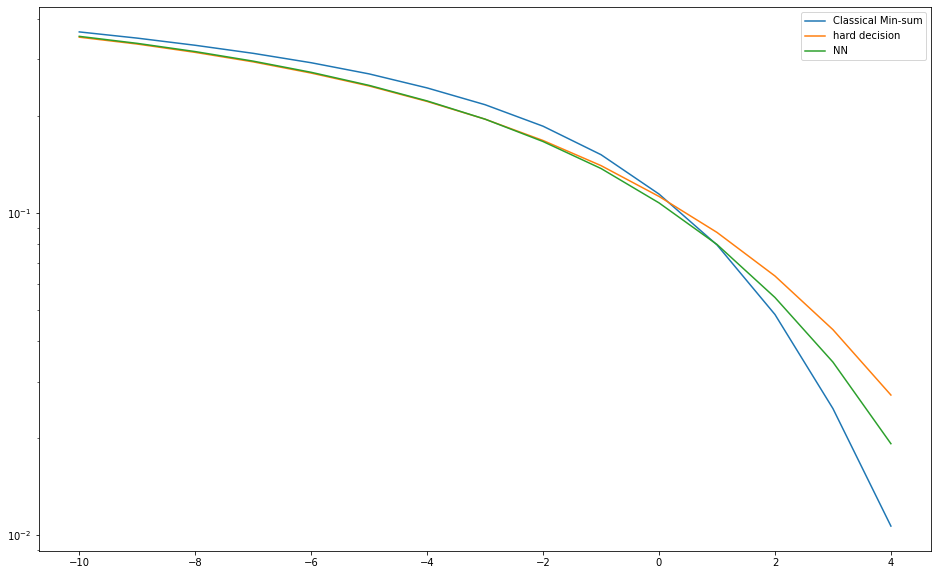

In [20]:
plt.figure(figsize=(16,10))
plt.semilogy(SNRs, bit_errors_min_sum.cpu() / nb_bits_min_sum.cpu(), label='Classical Min-sum')
plt.semilogy(SNRs, bit_errors_hard.cpu() / nb_bits_hard.cpu(), label='hard decision')
# for i in range(10):
plt.semilogy(SNRs, bit_errors_nn[-1].cpu() / nb_bits_nn[-1].cpu(), label=f'NN')
plt.legend()
plt.show()

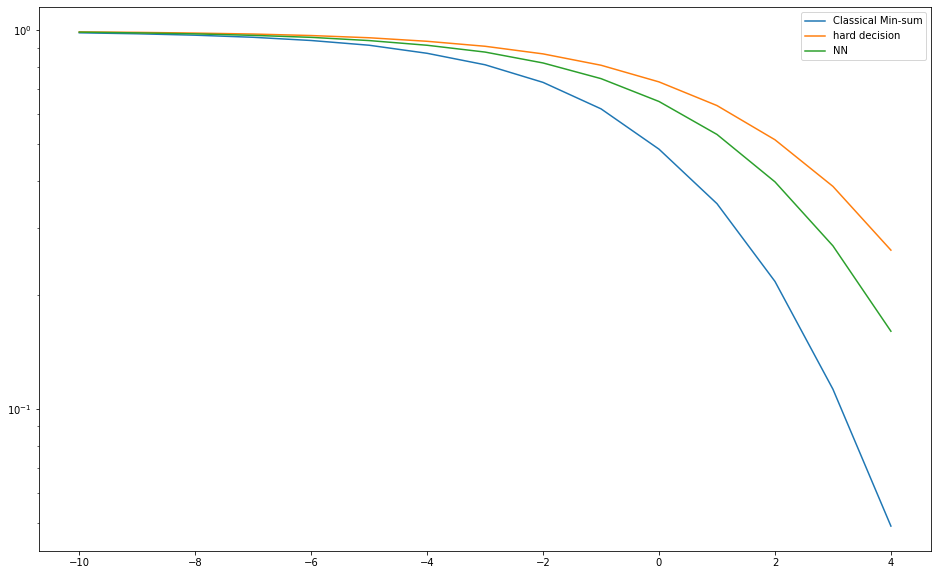

In [21]:
plt.figure(figsize=(16,10))
plt.semilogy(SNRs, frame_errors_min_sum.cpu() / nb_frames_min_sum.cpu(), label='Classical Min-sum')
plt.semilogy(SNRs, frame_errors_hard.cpu() / nb_frames_hard.cpu(), label='hard decision')
# for i in range(10):
plt.semilogy(SNRs, frame_errors_nn[-1].cpu() / nb_frames_nn[-1].cpu(), label=f'NN')
plt.legend()
plt.show()

In [22]:
decoder(soft_input)[0] - 0.5

tensor([ 0.1687,  0.0670, -0.2744, -0.1337,  0.2672,  0.2986,  0.3985,  0.2603,
        -0.3639,  0.2559, -0.1473, -0.2106,  0.3271,  0.1532,  0.3012],
       device='cuda:1', grad_fn=<SubBackward0>)

In [17]:
codewords[0]

tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1], device='cuda:1')

In [18]:
decoder.W_vc

Parameter containing:
tensor([[1.4234e-05, 1.1756e+00, 5.9546e-01, 1.0038e+00, 1.5947e+00, 1.1011e-06,
         4.0040e-01, 1.2722e+00, 1.8151e+00, 1.7389e-01, 4.4487e-01, 7.8096e-02,
         5.4148e-01, 1.0465e+00, 8.9780e-01, 1.1935e+00, 2.0636e-01, 1.6138e+00,
         1.2011e+00, 1.7642e+00, 2.2990e+00, 6.7812e-01, 7.5391e-01, 1.5526e-01,
         5.4060e-01, 9.4674e-01, 1.6475e+00, 1.2184e-01, 5.3433e-01, 8.1130e-01,
         1.7138e+00, 1.2715e+00],
        [7.3622e-01, 6.6666e-01, 4.1471e-01, 4.8693e-01, 5.0636e-01, 3.5290e-01,
         9.1804e-01, 4.9492e-01, 1.0990e+00, 5.2720e-01, 1.4519e+00, 4.4339e-01,
         8.2945e-01, 4.5176e-01, 3.5736e-01, 1.1271e+00, 4.4045e-01, 3.7998e-01,
         5.3097e-01, 7.0437e-01, 2.0556e+00, 5.4822e-01, 4.2564e-01, 1.7236e+00,
         8.6979e-01, 1.0478e+00, 1.5578e+00, 1.1677e+00, 6.4219e-01, 6.6561e-01,
         5.2256e-01, 4.0501e-01],
        [2.1011e-01, 1.2836e-01, 1.8296e-01, 2.3499e-01, 1.4856e+00, 1.4617e+00,
         5.8581e-01

In [19]:
decoder.B_cv

Parameter containing:
tensor([[0.7695, 0.0292, 0.6148, 0.4295, 1.9167, 1.1184, 1.2790, 0.5783, 0.0822,
         0.3759, 0.1054, 2.0407, 0.4687, 1.0309, 0.0247, 0.5924, 1.6069, 0.7487,
         0.3442, 0.0862, 1.6394, 0.0263, 1.3829, 0.3566, 1.1157, 0.3647, 1.2820,
         0.0901, 0.8547, 1.1350, 0.5673, 0.0381],
        [1.1469, 0.1957, 0.0715, 0.4677, 0.1407, 0.4222, 0.8109, 0.7770, 1.1982,
         0.4392, 1.4960, 0.2807, 0.4314, 0.1515, 0.3019, 1.6587, 1.5424, 0.3088,
         0.2030, 1.7567, 1.2404, 2.1583, 1.0773, 0.5413, 0.0730, 0.7536, 0.8519,
         0.4292, 0.9579, 0.2738, 0.1292, 0.4906],
        [0.8637, 0.3036, 1.1030, 0.5077, 1.1506, 0.5193, 0.1799, 0.3363, 1.4930,
         0.1597, 1.0060, 0.2414, 0.8114, 0.9973, 0.8874, 0.4875, 0.4463, 0.3082,
         0.7520, 0.7720, 0.5902, 1.3876, 2.3986, 0.5131, 0.1662, 0.7433, 2.3712,
         1.0596, 0.4249, 0.7075, 0.0126, 0.2077],
        [0.3095, 1.5589, 0.4324, 0.5584, 0.0566, 1.2143, 0.7122, 0.0672, 2.0786,
         1.2681, 0